# Route Analysis Dataset Exploration

This notebook explores the route analysis dataset, which contains receiver route metrics including:
- Route types and frequencies
- Success rates (completion percentage)
- Separation metrics (distance to ball at landing)
- Route characteristics (depth, width, distance)

The dataset contains one row per targeted receiver per play.

## Setup and Imports

In [4]:
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nfl_analysis import RouteVisualizer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

## Load Route Analysis Dataset

In [9]:
# Load the route analysis dataset
route_df = pd.read_parquet('../data/consolidated/route_analysis.parquet')

print(f"Dataset Shape: {route_df.shape}")
print(f"\nColumns: {len(route_df.columns)}")
print(f"Routes: {len(route_df):,}")

Dataset Shape: (14108, 39)

Columns: 39
Routes: 14,108


## Dataset Overview

In [10]:
# Display first few rows
route_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_at_release,y_at_release,speed_at_release,acceleration_at_release,direction_at_release,orientation_at_release,num_frames_output,ball_land_x,ball_land_y,week,x_at_landing,y_at_landing,frames_post_pass,route_type,pass_result,team_coverage_type,team_coverage_man_zone,offense_formation,receiver_alignment,dist_to_ball_at_landing,route_depth,route_width,route_distance,dist_to_ball_at_release,is_completion
0,2023090700,101,True,44930,26,right,42,Josh Reynolds,6-3,196,1995-02-16,WR,Offense,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22,1,62.49,2.83,21,CORNER,I,COVER_2_ZONE,ZONE_COVERAGE,SHOTGUN,2x2,3.145695,10.06,-11.31,15.136700,17.986063,0
1,2023090700,194,True,41325,32,left,89,Jerick McKinnon,5-9,205,1992-05-03,RB,Offense,Targeted Receiver,88.98,22.23,6.09,2.14,245.74,314.63,9,84.940002,21.75,1,84.06,20.70,9,ANGLE,C,COVER_1_MAN,MAN_COVERAGE,SHOTGUN,2x2,1.370002,4.92,1.53,5.152407,4.068413,1
2,2023090700,219,True,53591,17,left,79,Noah Gray,6-4,240,1999-04-30,TE,Offense,Targeted Receiver,75.98,10.22,3.85,2.77,268.92,343.54,8,75.849998,11.49,1,74.39,9.91,8,HITCH,C,COVER_4_ZONE,ZONE_COVERAGE,SHOTGUN,2x2,2.151277,1.59,0.31,1.619938,1.276636,1
3,2023090700,361,True,38696,51,right,22,Marvin Jones,6-2,198,1990-03-12,WR,Offense,Targeted Receiver,34.19,48.33,1.51,3.87,18.99,194.89,16,26.100000,49.18,1,28.74,50.94,16,HITCH,C,COVER_4_ZONE,ZONE_COVERAGE,SHOTGUN,3x1,3.172885,-5.45,2.61,6.042731,8.134531,1
4,2023090700,436,True,53541,20,right,31,Amon-Ra St. Brown,6-1,195,1999-10-24,WR,Offense,Targeted Receiver,33.67,37.80,3.59,6.08,116.90,136.35,7,34.889999,34.82,1,35.58,35.35,7,SLANT,C,COVER_1_MAN,MAN_COVERAGE,SHOTGUN,2x2,0.870058,1.91,-2.45,3.106541,3.220062,1


In [11]:
# Column information
route_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14108 entries, 0 to 14107
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   game_id                   14108 non-null  int64  
 1   play_id                   14108 non-null  int64  
 2   player_to_predict         14108 non-null  bool   
 3   nfl_id                    14108 non-null  int64  
 4   frame_id                  14108 non-null  int64  
 5   play_direction            14108 non-null  object 
 6   absolute_yardline_number  14108 non-null  int64  
 7   player_name               14108 non-null  object 
 8   player_height             14108 non-null  object 
 9   player_weight             14108 non-null  int64  
 10  player_birth_date         14108 non-null  object 
 11  player_position           14108 non-null  object 
 12  player_side               14108 non-null  object 
 13  player_role               14108 non-null  object 
 14  x_at_r

In [12]:
# Statistical summary
route_df.describe()

,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x_at_release,y_at_release,speed_at_release,acceleration_at_release,direction_at_release,orientation_at_release,num_frames_output,ball_land_x,ball_land_y,week,x_at_landing,y_at_landing,frames_post_pass,dist_to_ball_at_landing,route_depth,route_width,route_distance,dist_to_ball_at_release,is_completion
count,1.410800e+04,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000,14108.000000
mean,2.023156e+09,2185.019847,49683.971435,28.133967,60.498511,212.952509,60.431466,26.738818,5.570075,3.065449,180.161739,177.422723,11.366601,60.475035,26.635479,9.439467,60.501913,26.651029,11.366601,1.593332,3.429503,-0.069479,6.600620,6.767635,0.690247
std,2.028605e+05,1248.069122,5201.054838,9.257372,23.262021,25.022106,23.610446,12.338320,1.922344,1.613864,104.352725,104.540701,5.147501,25.283144,15.259020,5.275868,25.250659,15.434360,5.147501,1.647969,5.263466,5.591433,5.211916,5.497056,0.462408
min,2.023091e+09,54.000000,30842.000000,8.000000,11.000000,153.000000,0.610000,0.680000,0.000000,0.000000,0.020000,0.000000,5.000000,-5.260000,-3.910000,1.000000,0.020000,0.330000,5.000000,0.000002,-13.130000,-21.980000,0.060000,0.022361,0.000000
25%,2.023101e+09,1129.750000,44959.000000,22.000000,41.000000,195.000000,42.997500,15.607500,4.297500,1.730000,91.257500,86.035000,8.000000,42.397501,13.530000,5.000000,42.690000,13.180000,8.000000,0.636396,0.660000,-4.330000,3.237561,3.233034,0.000000
50%,2.023111e+09,2158.000000,52425.000000,26.000000,61.000000,210.000000,60.255000,26.555000,5.805000,2.970000,178.560000,178.690000,10.000000,60.490002,26.480000,9.000000,60.580000,26.470000,10.000000,1.186045,1.650000,-0.160000,5.251419,5.296494,1.000000
75%,2.023121e+09,3234.000000,54509.000000,32.000000,80.000000,231.000000,77.810000,37.980000,6.950000,4.290000,269.792500,263.750000,13.000000,78.550003,39.619999,14.000000,78.365000,39.940000,13.000000,1.980701,3.530000,4.180000,8.087422,8.180734,1.000000
max,2.024011e+09,5258.000000,56663.000000,123.000000,109.000000,338.000000,119.270000,52.610000,10.340000,8.360000,359.980000,359.960000,94.000000,125.849998,57.330002,18.000000,120.830000,53.720000,94.000000,50.979024,31.050000,23.380000,33.456064,49.740375,1.000000


## Route Type Distribution

In [38]:
# Route type counts
route_counts = route_df['route_type'].value_counts().sort_index()
print("Route Type Distribution:")
print(route_counts)
print(f"\nTotal Routes: {route_counts.sum():,}")
print(f"Unique Route Types: {len(route_counts)}")

Route Type Distribution:
route_type
ANGLE      544
CORNER     509
CROSS     1496
FLAT      1983
GO        1397
HITCH     2660
IN        1107
OUT       2214
POST       769
SCREEN     301
SLANT     1049
WHEEL       76
Name: count, dtype: int64

Total Routes: 14,105
Unique Route Types: 12


## Success Rate Analysis

In [39]:
# Overall completion rate
overall_completion = route_df['is_completion'].mean() * 100
print(f"Overall Completion Rate: {overall_completion:.1f}%")

# Completion rate by route type
completion_by_route = route_df.groupby('route_type').agg({
    'is_completion': ['mean', 'sum', 'count']
}).round(3)
completion_by_route.columns = ['Completion_Rate', 'Completions', 'Attempts']
completion_by_route['Completion_Pct'] = (completion_by_route['Completion_Rate'] * 100).round(1)
completion_by_route = completion_by_route.sort_values('Completion_Rate', ascending=False)

print("\nCompletion Rate by Route Type:")
completion_by_route

Overall Completion Rate: 69.0%

Completion Rate by Route Type:


,Completion_Rate,Completions,Attempts,Completion_Pct
route_type,,,,
SCREEN,0.864,260,301,86.4
FLAT,0.850,1686,1983,85.0
ANGLE,0.831,452,544,83.1
HITCH,0.762,2026,2660,76.2
SLANT,0.711,746,1049,71.1
CROSS,0.709,1061,1496,70.9
OUT,0.696,1542,2214,69.6
IN,0.600,664,1107,60.0
POST,0.550,423,769,55.0


## Separation Analysis

In [40]:
# Distance to ball at landing statistics
print("Distance to Ball at Landing (yards):")
print(route_df['dist_to_ball_at_landing'].describe())

# By route type
separation_by_route = route_df.groupby('route_type')['dist_to_ball_at_landing'].agg([
    'mean', 'median', 'std', 'min', 'max'
]).round(2).sort_values('mean')

print("\nSeparation by Route Type (yards):")
separation_by_route

Distance to Ball at Landing (yards):
count    14108.000000
mean         1.593332
std          1.647969
min          0.000002
25%          0.636396
50%          1.186045
75%          1.980701
max         50.979024
Name: dist_to_ball_at_landing, dtype: float64

Separation by Route Type (yards):


,mean,median,std,min,max
route_type,,,,,
ANGLE,1.21,0.95,1.00,0.08,9.08
FLAT,1.21,0.92,1.05,0.01,14.11
CROSS,1.53,1.16,1.48,0.04,13.68
WHEEL,1.54,0.95,1.75,0.15,9.88
SCREEN,1.55,1.13,3.09,0.10,50.98
HITCH,1.61,1.18,1.54,0.02,17.83
OUT,1.62,1.28,1.58,0.00,29.74
SLANT,1.63,1.22,1.72,0.04,19.33
CORNER,1.75,1.34,1.48,0.06,9.24


## Route Characteristics

In [41]:
# Route metrics by type
route_metrics = route_df.groupby('route_type').agg({
    'route_depth': 'mean',
    'route_width': 'mean',
    'route_distance': 'mean',
    'speed_at_release': 'mean'
}).round(2)

print("Route Characteristics by Type:")
route_metrics

Route Characteristics by Type:


,route_depth,route_width,route_distance,speed_at_release
route_type,,,,
ANGLE,1.70,-0.09,2.63,3.95
CORNER,8.54,0.61,13.15,7.18
CROSS,2.15,0.23,7.61,7.33
FLAT,1.51,-0.52,5.20,5.80
GO,13.86,0.11,15.03,7.18
HITCH,0.88,-0.11,2.41,3.51
IN,1.66,0.25,5.42,5.36
OUT,1.45,-0.14,6.78,5.66
POST,8.14,-0.11,10.78,7.06


## Top Receivers Analysis

In [42]:
# Top targeted receivers
top_receivers = route_df.groupby('player_name').agg({
    'nfl_id': 'first',
    'is_completion': ['count', 'sum', 'mean'],
    'dist_to_ball_at_landing': 'mean'
}).round(3)

top_receivers.columns = ['NFL_ID', 'Targets', 'Completions', 'Catch_Rate', 'Avg_Separation']
top_receivers['Catch_Pct'] = (top_receivers['Catch_Rate'] * 100).round(1)
top_receivers['Avg_Separation'] = top_receivers['Avg_Separation'].round(2)

# Filter to receivers with at least 20 targets
top_receivers = top_receivers[top_receivers['Targets'] >= 20]
top_receivers = top_receivers.sort_values('Targets', ascending=False)

print(f"Top Receivers (min 20 targets): {len(top_receivers)}")
top_receivers.head(20)

Top Receivers (min 20 targets): 224


,NFL_ID,Targets,Completions,Catch_Rate,Avg_Separation,Catch_Pct
player_name,,,,,,
CeeDee Lamb,52425,165,125,0.758,1.44,75.8
Davante Adams,41282,155,94,0.606,2.04,60.6
Garrett Wilson,54475,143,85,0.594,1.94,59.4
Amon-Ra St. Brown,53541,139,101,0.727,1.61,72.7
A.J. Brown,47834,139,101,0.727,1.53,72.7
Tyreek Hill,43454,133,91,0.684,1.41,68.4
Puka Nacua,56042,130,88,0.677,1.84,67.7
Keenan Allen,40024,129,95,0.736,1.69,73.6
Stefon Diggs,42489,127,84,0.661,1.71,66.1


## Coverage Type Analysis

In [43]:
# Success rate by coverage type
coverage_analysis = route_df.groupby('team_coverage_man_zone').agg({
    'is_completion': ['count', 'mean'],
    'dist_to_ball_at_landing': 'mean'
}).round(3)

coverage_analysis.columns = ['Attempts', 'Completion_Rate', 'Avg_Separation']
coverage_analysis['Completion_Pct'] = (coverage_analysis['Completion_Rate'] * 100).round(1)

print("Success Rate by Coverage Type:")
coverage_analysis

Success Rate by Coverage Type:


,Attempts,Completion_Rate,Avg_Separation,Completion_Pct
team_coverage_man_zone,,,,
MAN_COVERAGE,4013,0.602,1.699,60.2
ZONE_COVERAGE,10092,0.726,1.550,72.6


## Visualizations Using RouteVisualizer

In [44]:
# Initialize RouteVisualizer
visualizer = RouteVisualizer(data_dir='../data/consolidated')
route_data = visualizer.load_route_data()

print(f"Loaded {len(route_data):,} routes for visualization")

Loaded 14,108 routes for visualization


### Route Frequency

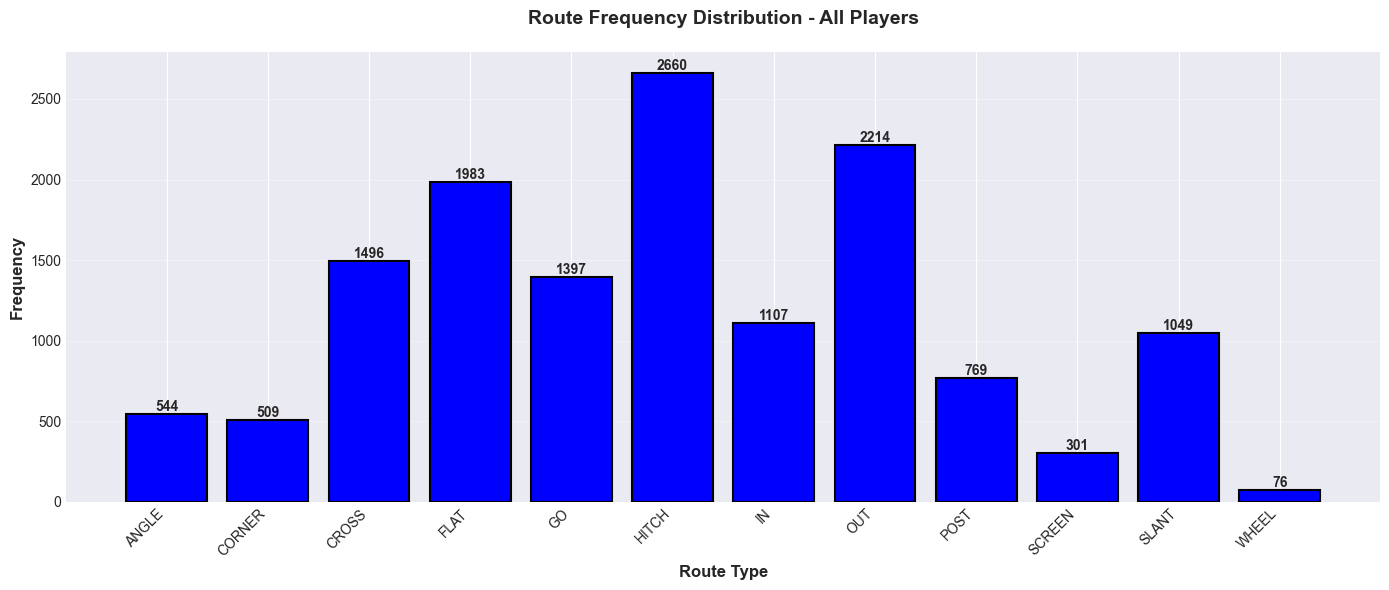

In [45]:
# Plot route frequency
fig, ax = visualizer.plot_route_frequency(figsize=(14, 6))
plt.tight_layout()
plt.show()

### Success Rate by Route Type

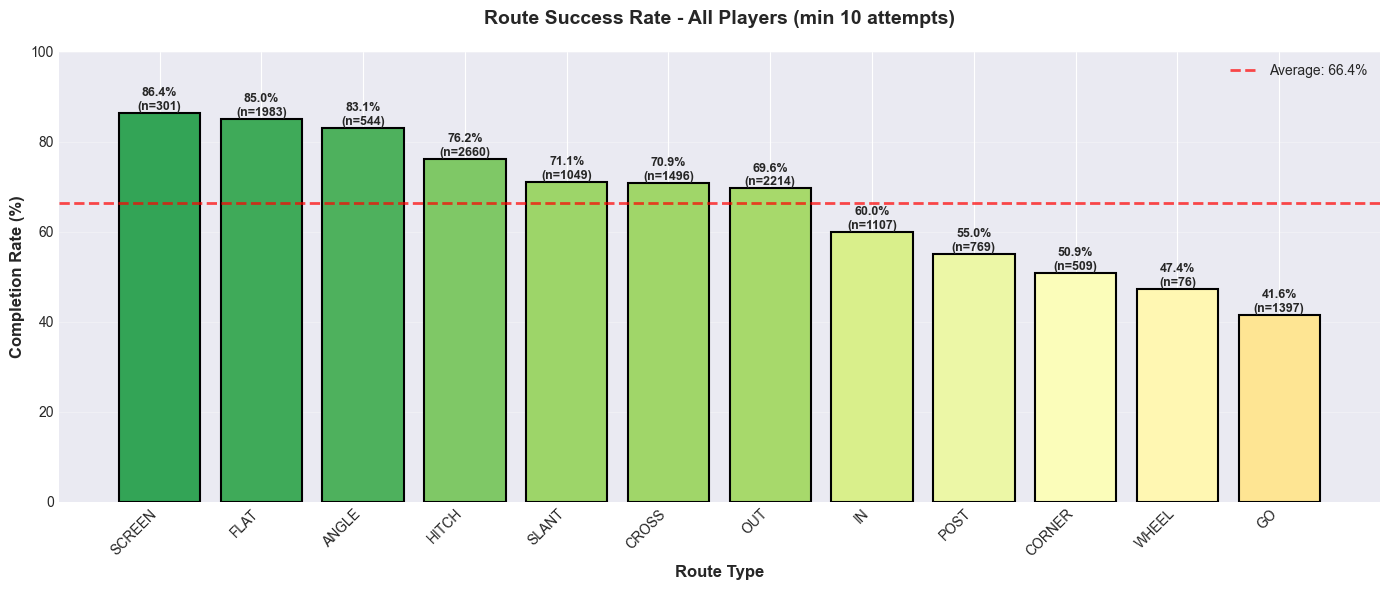

In [46]:
# Plot success rate
fig, ax = visualizer.plot_route_success_rate(min_attempts=10, figsize=(14, 6))
plt.tight_layout()
plt.show()

### Separation by Route Type

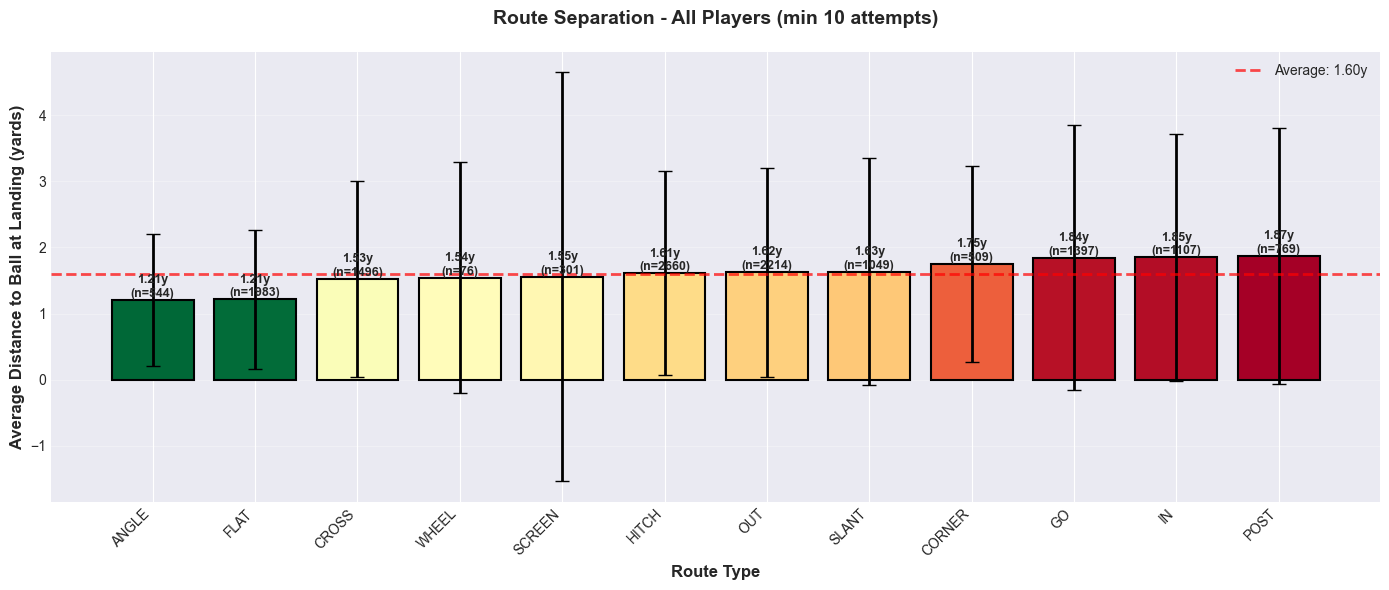

In [47]:
# Plot separation
fig, ax = visualizer.plot_route_separation(min_attempts=10, figsize=(14, 6))
plt.tight_layout()
plt.show()

### Comprehensive Dashboard

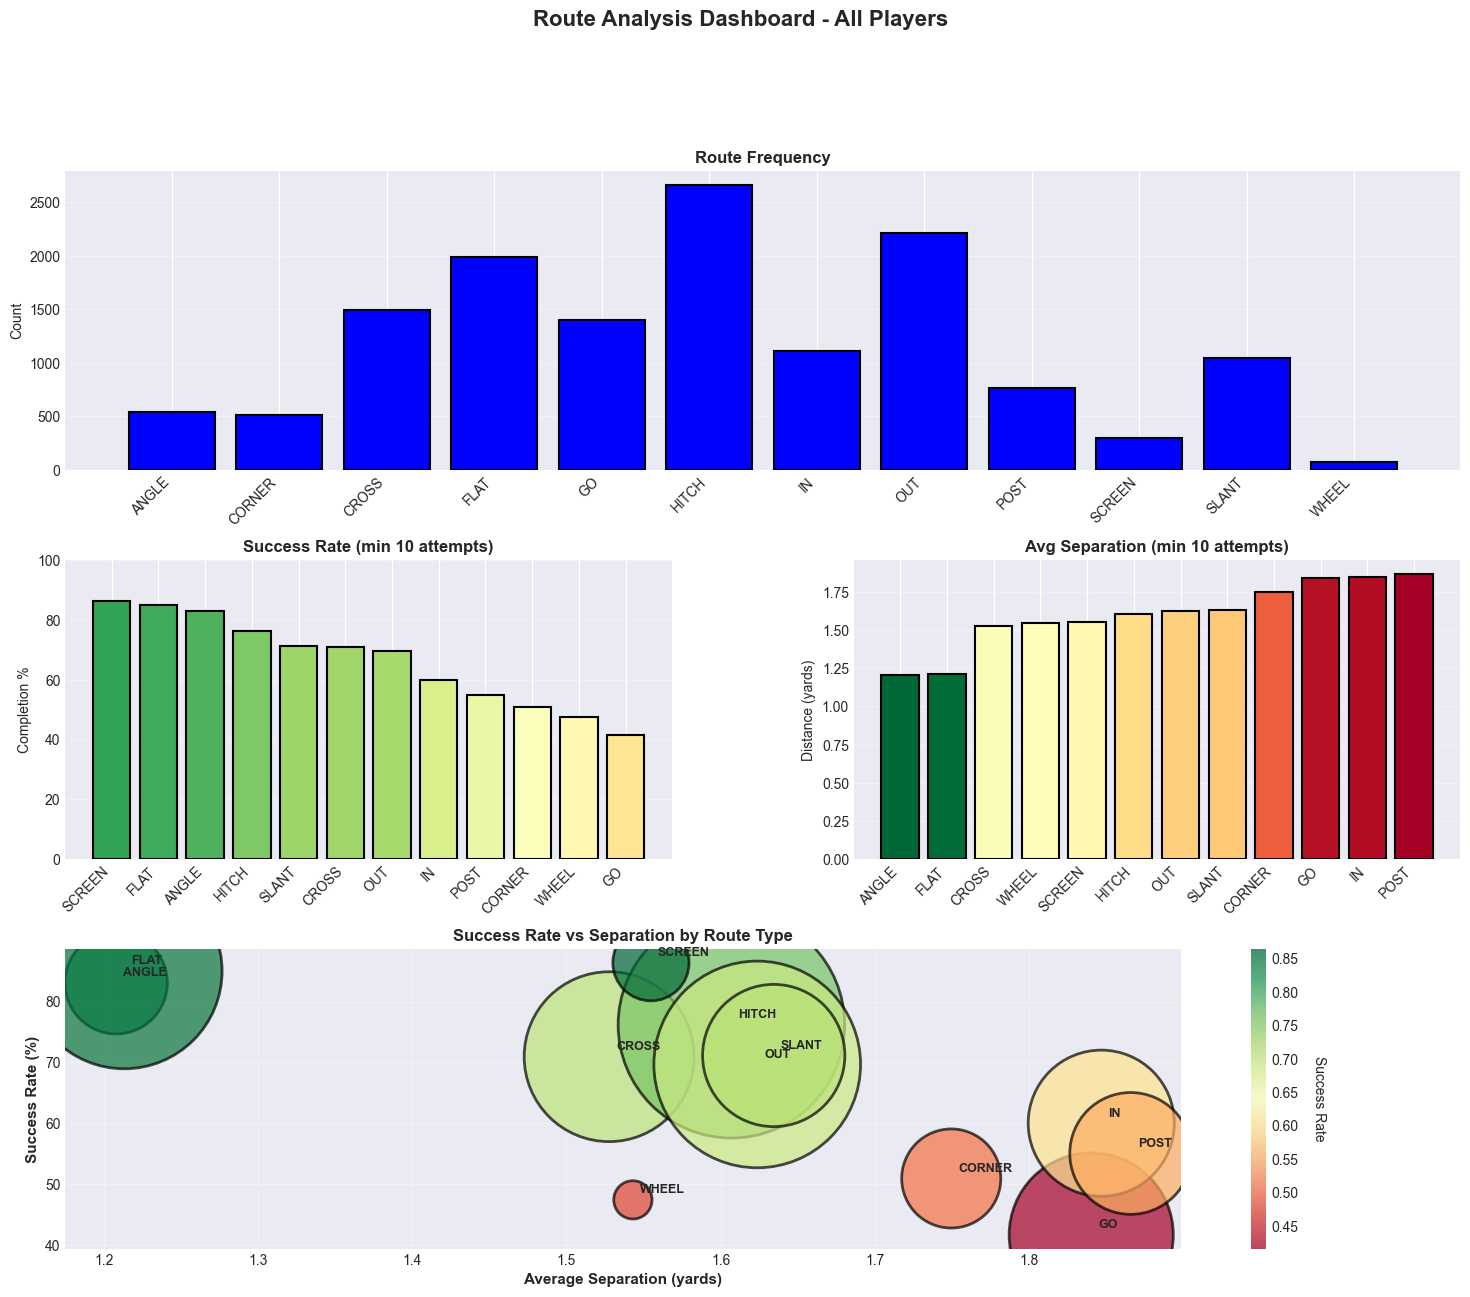

In [48]:
# Create full dashboard
fig, axes = visualizer.plot_route_dashboard(min_attempts=10, figsize=(18, 14))
plt.tight_layout()
plt.show()

## Player-Specific Analysis

In [49]:
# Get a specific player's route data
# Let's look at the most targeted receiver
top_player = top_receivers.index[0]
print(f"Analyzing routes for: {top_player}")

player_routes = route_df[route_df['player_name'] == top_player]
print(f"\nTotal targets: {len(player_routes)}")
print(f"Completion rate: {player_routes['is_completion'].mean()*100:.1f}%")
print(f"Average separation: {player_routes['dist_to_ball_at_landing'].mean():.2f} yards")

print("\nRoute distribution:")
print(player_routes['route_type'].value_counts())

Analyzing routes for: CeeDee Lamb

Total targets: 165
Completion rate: 75.8%
Average separation: 1.44 yards

Route distribution:
route_type
OUT       29
HITCH     29
SLANT     28
GO        25
CROSS     17
POST      12
IN         9
CORNER     8
FLAT       5
SCREEN     2
ANGLE      1
Name: count, dtype: int64


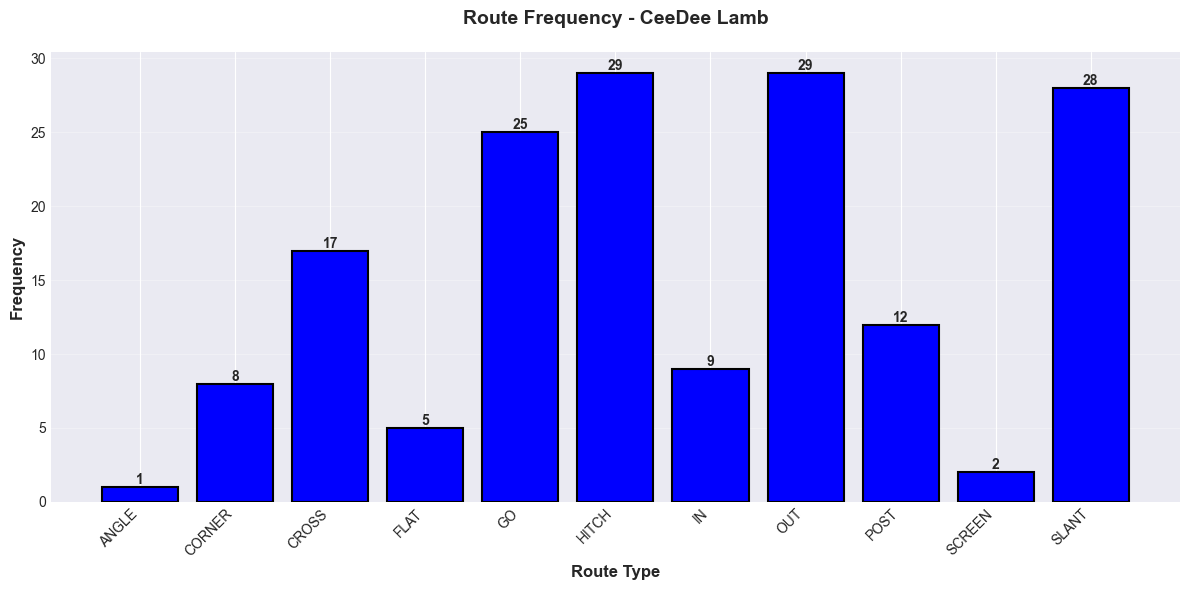

In [50]:
# Visualize specific player's routes
fig, ax = visualizer.plot_route_frequency(player_name=top_player, figsize=(12, 6))
plt.tight_layout()
plt.show()

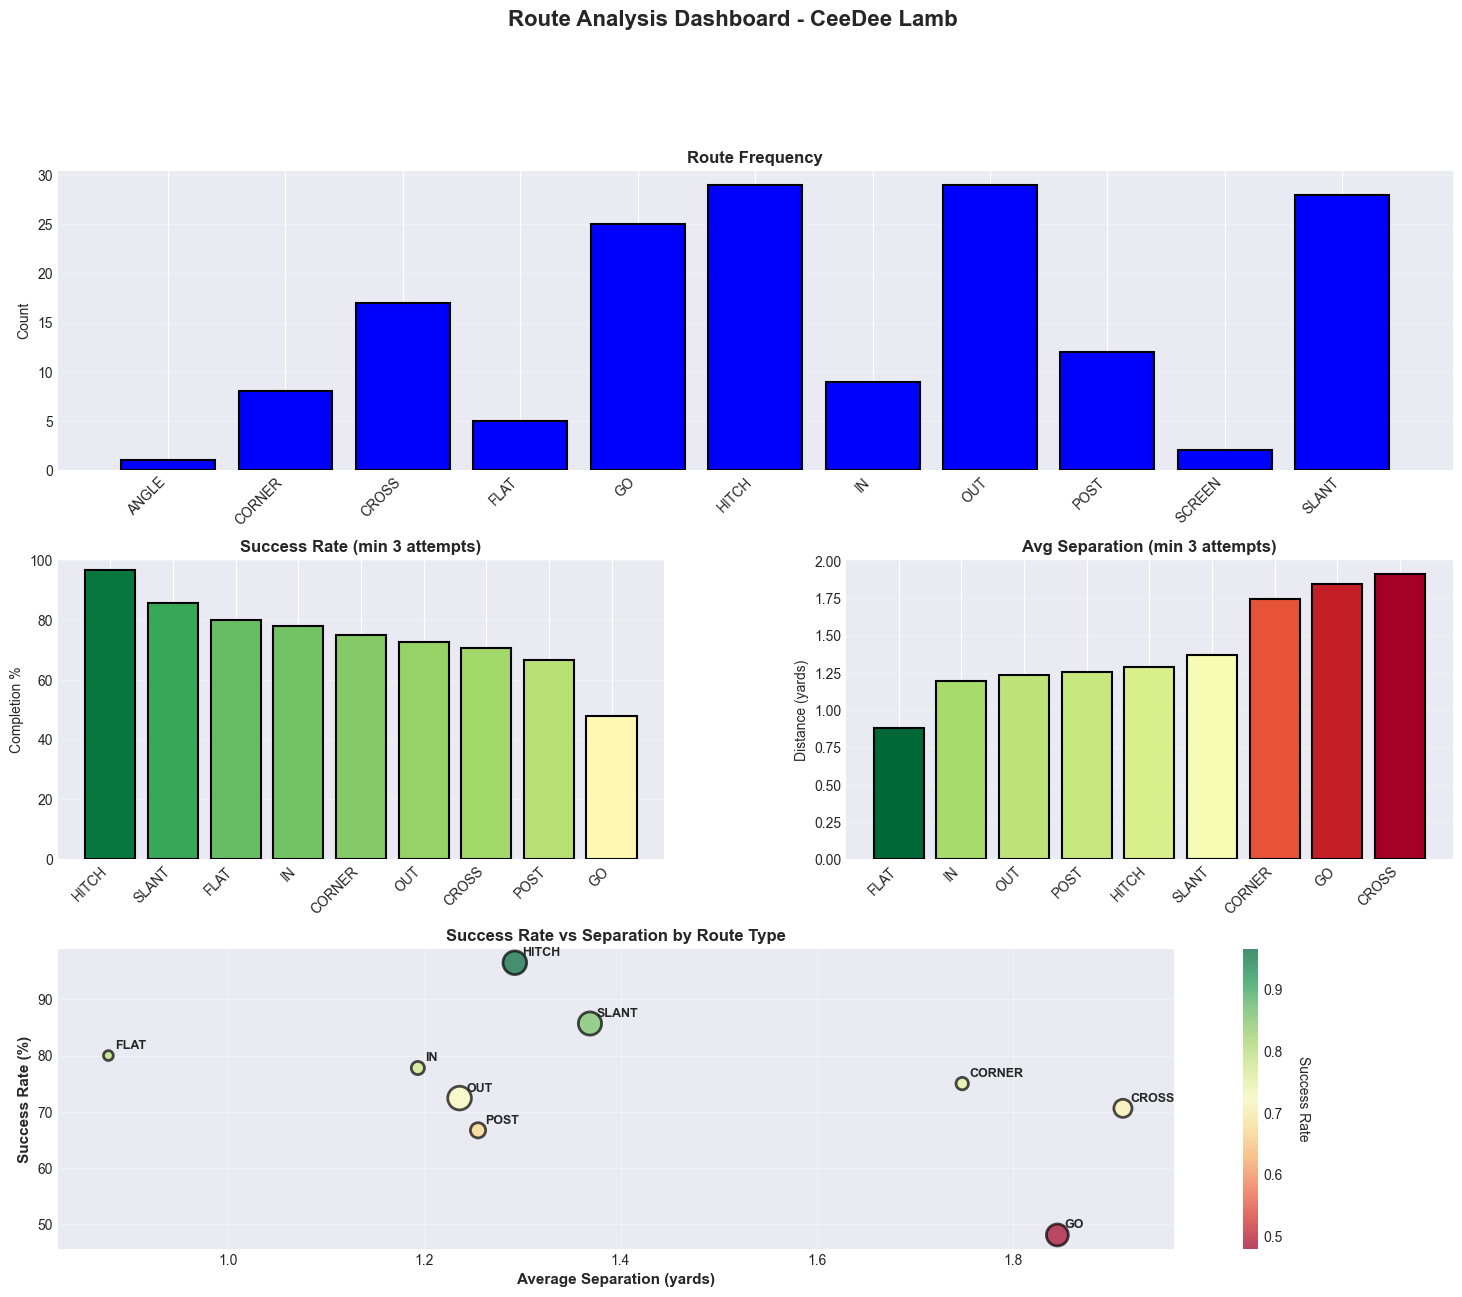

In [51]:
# Player-specific dashboard
fig, axes = visualizer.plot_route_dashboard(
    player_name=top_player,
    min_attempts=3,
    figsize=(18, 14)
)
plt.tight_layout()
plt.show()

## Custom Analysis: Route Efficiency

In [52]:
# Calculate route efficiency: completion rate vs average separation
route_efficiency = route_df.groupby('route_type').agg({
    'is_completion': ['mean', 'count'],
    'dist_to_ball_at_landing': 'mean'
}).round(3)

route_efficiency.columns = ['Completion_Rate', 'Count', 'Avg_Separation']
route_efficiency = route_efficiency[route_efficiency['Count'] >= 10]

# Calculate efficiency score (higher completion, lower separation = better)
route_efficiency['Efficiency_Score'] = (
    route_efficiency['Completion_Rate'] / (route_efficiency['Avg_Separation'] + 0.1)
).round(3)

route_efficiency = route_efficiency.sort_values('Efficiency_Score', ascending=False)

print("Route Efficiency (Completion Rate / Avg Separation):")
route_efficiency

Route Efficiency (Completion Rate / Avg Separation):


,Completion_Rate,Count,Avg_Separation,Efficiency_Score
route_type,,,,
FLAT,0.850,1983,1.213,0.647
ANGLE,0.831,544,1.208,0.635
SCREEN,0.864,301,1.555,0.522
HITCH,0.762,2660,1.607,0.446
CROSS,0.709,1496,1.528,0.436
SLANT,0.711,1049,1.634,0.410
OUT,0.696,2214,1.624,0.404
IN,0.600,1107,1.847,0.308
WHEEL,0.474,76,1.543,0.288


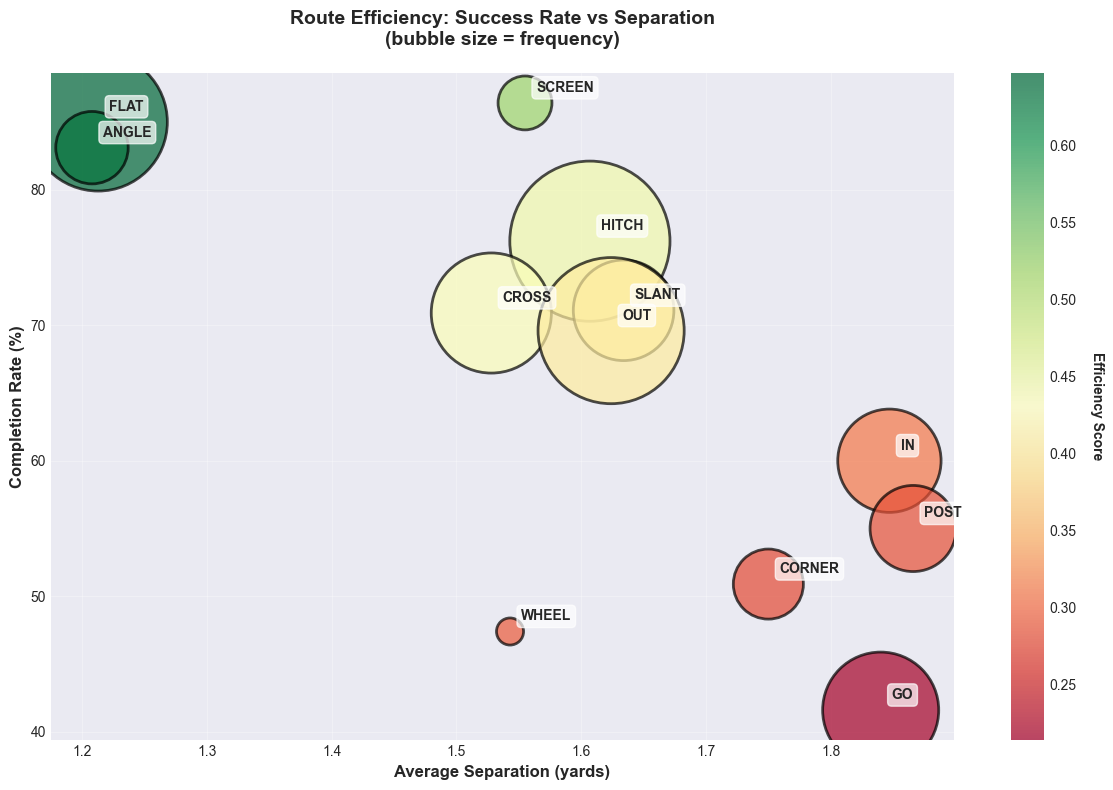

In [53]:
# Scatter plot: Success Rate vs Separation
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    route_efficiency['Avg_Separation'],
    route_efficiency['Completion_Rate'] * 100,
    s=route_efficiency['Count'] * 5,
    c=route_efficiency['Efficiency_Score'],
    cmap='RdYlGn',
    alpha=0.7,
    edgecolor='black',
    linewidth=2
)

# Add labels for each point
for route, row in route_efficiency.iterrows():
    ax.annotate(
        route,
        (row['Avg_Separation'], row['Completion_Rate'] * 100),
        xytext=(8, 8),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
    )

ax.set_xlabel('Average Separation (yards)', fontsize=12, fontweight='bold')
ax.set_ylabel('Completion Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Route Efficiency: Success Rate vs Separation\n(bubble size = frequency)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Efficiency Score', rotation=270, labelpad=20, fontweight='bold')

plt.tight_layout()
plt.show()

## Summary Statistics

In [54]:
print("=" * 70)
print("ROUTE ANALYSIS DATASET SUMMARY")
print("=" * 70)
print(f"\nTotal Routes: {len(route_df):,}")
print(f"Unique Players: {route_df['nfl_id'].nunique()}")
print(f"Unique Games: {route_df['game_id'].nunique()}")
print(f"Unique Plays: {route_df.groupby(['game_id', 'play_id']).ngroups:,}")
print(f"\nRoute Types: {route_df['route_type'].nunique()}")
print(f"Overall Completion Rate: {route_df['is_completion'].mean()*100:.1f}%")
print(f"Average Separation: {route_df['dist_to_ball_at_landing'].mean():.2f} yards")
print(f"\nMost Common Route: {route_df['route_type'].mode()[0]} ({route_df['route_type'].value_counts().iloc[0]} times)")
print(f"Highest Success Rate: {completion_by_route['Completion_Pct'].idxmax()} ({completion_by_route['Completion_Pct'].max():.1f}%)")
print(f"Best Separation: {separation_by_route['mean'].idxmin()} ({separation_by_route['mean'].min():.2f} yards)")
print("\n" + "=" * 70)

ROUTE ANALYSIS DATASET SUMMARY

Total Routes: 14,108
Unique Players: 464
Unique Games: 272
Unique Plays: 14,108

Route Types: 12
Overall Completion Rate: 69.0%
Average Separation: 1.59 yards

Most Common Route: HITCH (2660 times)
Highest Success Rate: SCREEN (86.4%)
Best Separation: ANGLE (1.21 yards)



In [20]:
route_df.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_height', 'player_weight', 'player_birth_date', 'player_position', 'player_side', 'player_role', 'x_at_release', 'y_at_release', 'speed_at_release', 'acceleration_at_release', 'direction_at_release', 'orientation_at_release', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'week', 'x_at_landing', 'y_at_landing', 'frames_post_pass', 'route_type', 'pass_result', 'team_coverage_type', 'team_coverage_man_zone', 'offense_formation', 'receiver_alignment', 'dist_to_ball_at_landing', 'route_depth', 'route_width', 'route_distance', 'dist_to_ball_at_release', 'is_completion'], dtype='object')

In [55]:
route_df.loc[route_df['play_direction'] == 'left']

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_at_release,y_at_release,speed_at_release,acceleration_at_release,direction_at_release,orientation_at_release,num_frames_output,ball_land_x,ball_land_y,week,x_at_landing,y_at_landing,frames_post_pass,route_type,pass_result,team_coverage_type,team_coverage_man_zone,offense_formation,receiver_alignment,dist_to_ball_at_landing,route_depth,route_width,route_distance,dist_to_ball_at_release,is_completion
1,2023090700,194,True,41325,32,left,89,Jerick McKinnon,5-9,205,1992-05-03,RB,Offense,Targeted Receiver,88.98,22.23,6.09,2.14,245.74,314.63,9,84.940002,21.750000,1,84.06,20.70,9,ANGLE,C,COVER_1_MAN,MAN_COVERAGE,SHOTGUN,2x2,1.370002,4.92,1.53,5.152407,4.068413,1
2,2023090700,219,True,53591,17,left,79,Noah Gray,6-4,240,1999-04-30,TE,Offense,Targeted Receiver,75.98,10.22,3.85,2.77,268.92,343.54,8,75.849998,11.490000,1,74.39,9.91,8,HITCH,C,COVER_4_ZONE,ZONE_COVERAGE,SHOTGUN,2x2,2.151277,1.59,0.31,1.619938,1.276636,1
8,2023090700,713,True,53591,24,left,83,Noah Gray,6-4,240,1999-04-30,TE,Offense,Targeted Receiver,79.36,12.20,4.47,4.22,214.38,178.75,8,79.910004,8.970000,1,78.53,8.01,8,OUT,I,COVER_4_ZONE,ZONE_COVERAGE,SHOTGUN,2x2,1.681074,0.83,4.19,4.271417,3.276492,0
9,2023090700,736,True,46213,31,left,83,Justin Watson,6-3,215,1996-04-04,WR,Offense,Targeted Receiver,73.35,33.42,7.84,3.28,311.65,332.64,15,68.470001,40.450001,1,66.97,41.43,15,CORNER,C,COVER_1_MAN,MAN_COVERAGE,SHOTGUN,3x1,1.791760,6.38,-8.01,10.240337,8.557762,1
13,2023090700,1069,True,53959,31,left,85,Brock Wright,6-4,255,1998-11-27,TE,Offense,Targeted Receiver,80.51,31.00,4.87,1.79,188.78,127.82,6,82.360001,29.030001,1,80.19,28.88,6,IN,C,COVER_3_ZONE,ZONE_COVERAGE,SINGLEBACK,3x1,2.175179,0.32,2.12,2.144015,2.702480,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14101,2024010713,3515,True,43454,15,left,82,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,77.24,13.64,7.18,1.49,270.99,286.36,12,70.730003,16.570000,18,69.26,15.48,12,POST,I,COVER_4_ZONE,ZONE_COVERAGE,EMPTY,3x2,1.830030,7.98,-1.84,8.189383,7.138974,0
14104,2024010713,3906,True,43454,19,left,73,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,68.78,10.17,7.00,4.07,235.35,334.03,13,67.669998,8.610000,18,65.92,6.78,13,HITCH,C,COVER_4_ZONE,ZONE_COVERAGE,SHOTGUN,3x1,2.532073,2.86,3.39,4.435279,1.914603,1
14105,2024010713,3936,True,46192,18,left,66,Durham Smythe,6-6,260,1995-08-09,TE,Offense,Targeted Receiver,61.46,30.82,3.95,5.06,303.10,309.19,8,61.139999,33.360001,18,60.35,33.61,8,OUT,C,COVER_2_MAN,MAN_COVERAGE,SHOTGUN,3x1,0.828613,1.11,-2.79,3.002699,2.560079,1
14106,2024010713,3995,True,43454,28,left,50,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,37.80,40.33,7.28,4.34,299.78,348.92,17,29.340000,47.660000,18,29.74,48.14,17,CORNER,I,COVER_2_ZONE,ZONE_COVERAGE,SHOTGUN,3x1,0.624820,8.06,-7.81,11.223177,11.193770,0


In [13]:
route_df.loc[(route_df['player_name'] == 'Tyreek Hill')]

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_at_release,y_at_release,speed_at_release,acceleration_at_release,direction_at_release,orientation_at_release,num_frames_output,ball_land_x,ball_land_y,week,x_at_landing,y_at_landing,frames_post_pass,route_type,pass_result,team_coverage_type,team_coverage_man_zone,offense_formation,receiver_alignment,dist_to_ball_at_landing,route_depth,route_width,route_distance,dist_to_ball_at_release,is_completion
561,2023091010,607,True,43454,32,right,35,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,51.04,20.97,9.55,2.91,59.14,57.59,26,67.019997,34.840000,1,69.91,35.96,26,CROSS,I,COVER_1_MAN,MAN_COVERAGE,SHOTGUN,2x2,3.099439,18.87,14.99,24.099315,21.159801,0
566,2023091010,1040,True,43454,28,left,87,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,75.31,39.15,8.72,3.96,260.57,236.36,16,69.449997,28.670000,1,66.52,30.87,16,POST,C,COVER_1_MAN,MAN_COVERAGE,SHOTGUN,2x2,3.663998,8.79,8.28,12.075699,12.007083,1
567,2023091010,1072,True,43454,32,left,58,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,43.74,28.82,8.99,3.80,234.26,226.77,15,40.000000,17.370001,1,36.88,17.74,15,CROSS,C,COVER_1_MAN,MAN_COVERAGE,I_FORM,1x1,3.141862,6.86,11.08,13.031731,12.045334,1
579,2023091010,1858,True,43454,25,left,52,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,44.97,13.30,6.41,2.28,266.96,249.09,15,36.830002,11.430000,1,35.45,10.39,15,CORNER,I,COVER_4_ZONE,ZONE_COVERAGE,SHOTGUN,3x1,1.728006,9.52,2.91,9.954823,8.352034,0
581,2023091010,1940,True,43454,24,left,42,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,33.11,40.45,8.24,3.99,253.32,213.45,12,27.150000,32.369999,1,25.65,34.00,12,POST,C,COVER_6_ZONE,ZONE_COVERAGE,EMPTY,4x1,2.215153,7.46,6.45,9.861749,10.040320,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14091,2024010713,2905,True,43454,22,left,73,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,63.93,36.90,7.27,3.91,257.35,225.37,11,58.869999,33.130001,18,58.84,33.42,11,POST,I,COVER_3_ZONE,ZONE_COVERAGE,PISTOL,2x1,0.291546,5.09,3.48,6.165914,6.310032,0
14099,2024010713,3467,True,43454,32,left,85,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,71.04,42.41,8.59,4.58,254.82,230.38,14,63.279999,35.959999,18,63.95,36.17,14,POST,I,COVER_2_ZONE,ZONE_COVERAGE,SHOTGUN,3x1,0.702141,7.09,6.24,9.444877,10.090596,0
14101,2024010713,3515,True,43454,15,left,82,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,77.24,13.64,7.18,1.49,270.99,286.36,12,70.730003,16.570000,18,69.26,15.48,12,POST,I,COVER_4_ZONE,ZONE_COVERAGE,EMPTY,3x2,1.830030,7.98,-1.84,8.189383,7.138974,0
14104,2024010713,3906,True,43454,19,left,73,Tyreek Hill,5-10,185,1994-03-01,WR,Offense,Targeted Receiver,68.78,10.17,7.00,4.07,235.35,334.03,13,67.669998,8.610000,18,65.92,6.78,13,HITCH,C,COVER_4_ZONE,ZONE_COVERAGE,SHOTGUN,3x1,2.532073,2.86,3.39,4.435279,1.914603,1


In [6]:
from nfl_analysis.visualization import RouteVisualizer
visualizer = RouteVisualizer(data_dir='../data/consolidated')

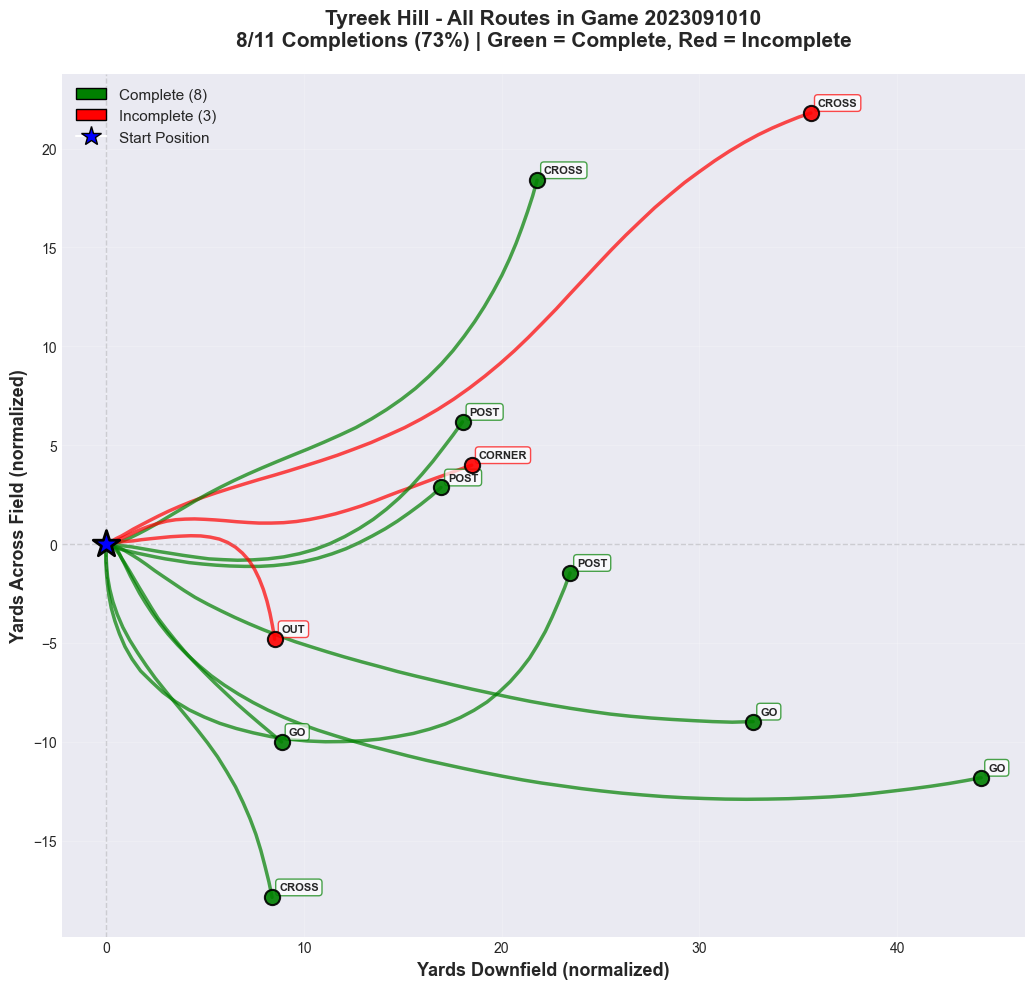

In [14]:
fig, ax = visualizer.plot_player_routes_overlay(
  game_id=2023091010,
  player_name='Tyreek Hill',
  save_path='my_routes.png'
)

In [2]:
print(dir(visualizer))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_filter_player_data', '_get_player_title', 'data_dir', 'load_route_data', 'plot_player_routes_overlay', 'plot_route_dashboard', 'plot_route_frequency', 'plot_route_separation', 'plot_route_success_rate', 'route_data']
